## BBC Experiment [Part 3 - More Object Detection]

- Initial Experiments are pretty mixed
- I'm really curious to see if we do any better when we solve jointly with **classification**. 
- I guess the other intersting thing here is **what's the minimum Ideas I can take from SSD or Yolo to make this work better**?
- Since I dont' have to worry about solving the multiple object problem, it *may* not be that much I need to change. 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from fastai.vision import *
from pathlib import Path
import pandas as pd
import json

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
path=Path('../data/bbc')

In [5]:
path.ls()

[PosixPath('../data/bbc/train.json'),
 PosixPath('../data/bbc/train_classification_labels.csv'),
 PosixPath('../data/bbc/test_classification_labels.csv'),
 PosixPath('../data/bbc/test'),
 PosixPath('../data/bbc/test.json'),
 PosixPath('../data/bbc/.DS_Store'),
 PosixPath('../data/bbc/train_masks'),
 PosixPath('../data/bbc/train'),
 PosixPath('../data/bbc/models'),
 PosixPath('../data/bbc/test_masks')]

In [6]:
labels=json.load(open(path/'train.json', 'r'))

In [7]:
labels.keys()

dict_keys(['images', 'annotations', 'type', 'categories'])

In [8]:
labels['annotations'][12]['bbox']

[282.39102564102564, 174.0, 70.19230769230762, 67.62820512820511]

In [9]:
images, lbl_bbox = get_annotations(path/'train.json')

In [10]:
images[:5]

['P2050936.jpg',
 'P2050922.jpg',
 'P2060163.jpg',
 'P2060003.jpg',
 'P2060017.jpg']

In [11]:
lbl_bbox[0]

[[[145.47435897435898,
   254.82692307692304,
   237.14102564102564,
   347.4551282051282]],
 ['ball']]

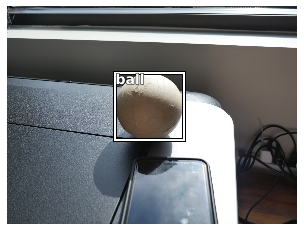

In [12]:
i=30
img = open_image(path/'train'/images[i])
bbox = ImageBBox.create(*img.size, lbl_bbox[i][0], [0], classes=['ball'])
img.show(figsize=(6,4), y=bbox)

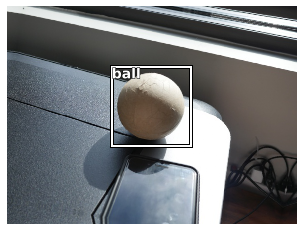

In [13]:
img = img.rotate(-10)
bbox = bbox.rotate(-10)
img.show(figsize=(6,4), y=bbox)

- Cool!

In [14]:
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

In [15]:
src = ObjectItemList.from_folder(path/'train')

In [16]:
def get_data(bs, size):
    src = ObjectItemList.from_folder(path/'train')
    src = src.split_by_rand_pct(0.2)
    src = src.label_from_func(get_y_func)
    src = src.transform(get_transforms(max_rotate=0), size=size, tfm_y=True)
    return src.databunch(path=path, bs=bs, collate_fn=bb_pad_collate)

In [17]:
data = get_data(64,256)

In [18]:
data

ImageDataBunch;

Train: LabelList (754 items)
x: ObjectItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ObjectCategoryList
ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256)
Path: ../data/bbc/train;

Valid: LabelList (188 items)
x: ObjectItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ObjectCategoryList
ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256)
Path: ../data/bbc/train;

Test: None

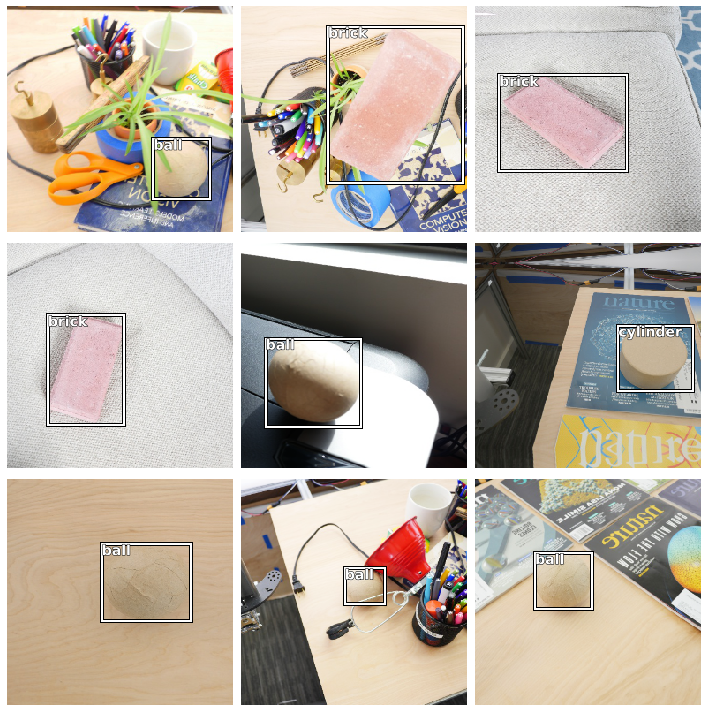

In [19]:
data.show_batch(rows=3, figsize=(10,10))

I can has learner with custom head?

In [39]:
class MyLoss(nn.Module):
    def forward(self, output, bbox_tgts, class_tgts):
        return nn.L1Loss()(output.unsqueeze_(dim=1), bbox_tgts)

In [40]:
custom_head = nn.Sequential(Flatten(), nn.Linear(32768, 4))

In [41]:
custom_head = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(32768,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4),
)

In [42]:
learn=cnn_learner(data, models.resnet34, custom_head=custom_head, loss_func=MyLoss())

In [43]:
learn.freeze()

In [44]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


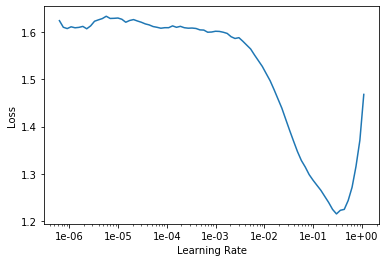

In [45]:
learn.recorder.plot()

- Woah, the lr fit results is super different with the `tanh`!
- Now, is learning faster?

In [46]:
lr=1e-2
learn.fit_one_cycle(4, slice(lr/10, lr))

epoch,train_loss,valid_loss,time
0,1.546233,1.918913,00:10
1,1.160912,0.607913,00:10
2,0.878033,0.244482,00:11
3,0.703953,0.215447,00:10


In [47]:
learn.unfreeze()

In [48]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


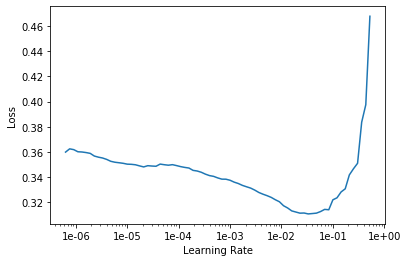

In [49]:
learn.recorder.plot()

In [50]:
lr=1e-3
learn.fit_one_cycle(8, slice(lr/10, lr))

epoch,train_loss,valid_loss,time
0,0.362040,0.158392,00:12
1,0.328636,0.173852,00:12
2,0.308274,0.177173,00:12
3,0.285786,0.132624,00:12
4,0.262352,0.106649,00:12
5,0.238211,0.089960,00:12
6,0.217764,0.072280,00:12
7,0.202655,0.066822,00:12


In [78]:
lr=5e-4
learn.fit_one_cycle(8, slice(lr/10, lr))

epoch,train_loss,valid_loss,time
0,0.150819,0.064243,00:12
1,0.144024,0.068506,00:12
2,0.143284,0.082753,00:12
3,0.139970,0.056314,00:12
4,0.134768,0.054209,00:12
5,0.129753,0.046481,00:12
6,0.125204,0.045240,00:12
7,0.122120,0.044434,00:12


In [79]:
learn.save('resnet-34-2-layer-head-stage-2')

- Woah, I think changing the head is really making a difference!
- Woohoo! Man, deep learning can really be tricky. 
- Like *why* do I need to fc layers?

In [80]:
x,y = learn.data.one_batch()
with torch.no_grad():
    yhat = learn.model(x.to('cuda'))

In [81]:
x.shape

torch.Size([64, 3, 256, 256])

In [82]:
x.dtype

torch.float32

In [83]:
x_numpy=np.moveaxis(x.cpu().numpy(), (0, 2, 3, 1), (0, 1, 2, 3))

In [84]:
x_numpy.shape

(64, 256, 256, 3)

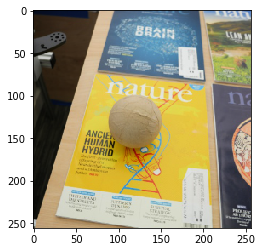

In [95]:
i=2
imshow(x_numpy[i])

In [96]:
y[0][i]

tensor([[-0.2253, -0.3086,  0.2692,  0.1828]])

In [97]:
size_stacked=torch.stack((torch.tensor(x.shape[2:]),
             torch.tensor(x.shape[2:]))).view(-1).to(torch.float)

In [98]:
size_stacked

tensor([256., 256., 256., 256.])

In [99]:
bounds=((y[0][i]+1)*size_stacked/2).numpy().ravel()

In [100]:
bounds

array([ 99.157776,  88.50075 , 162.45895 , 151.40193 ], dtype=float32)

In [101]:
corners=np.array([[bounds[1], bounds[0]], 
                  [bounds[3], bounds[0]],
                  [bounds[3], bounds[2]],
                  [bounds[1], bounds[2]],
                  [bounds[1], bounds[0]]])

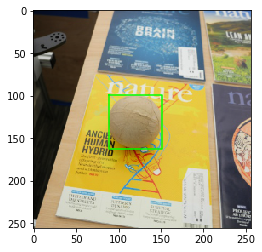

In [102]:
imshow(x_numpy[i])
plot(corners[:, 0], corners[:,1], c=(0, 1, 0))

- Ok, got it I think!

In [103]:
bounds=((yhat[i].cpu()+1)*size_stacked/2).numpy().ravel()

#This needs to be a function
corners=np.array([[bounds[1], bounds[0]], 
                  [bounds[3], bounds[0]],
                  [bounds[3], bounds[2]],
                  [bounds[1], bounds[2]],
                  [bounds[1], bounds[0]]])

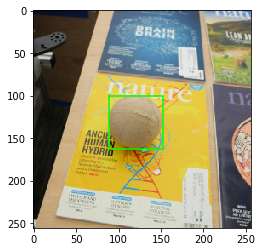

In [104]:
imshow(x_numpy[i])
plot(corners[:, 0], corners[:,1], c=(0, 1, 0))

Nailed it!

In [66]:
y[0][:5]

tensor([[[-0.5413, -0.6241,  0.6323,  0.5583]],

        [[-0.1239, -0.5306,  0.2952, -0.1160]],

        [[-0.1197, -0.2377,  0.2659,  0.1574]],

        [[-0.4700, -0.6551,  0.3179,  0.7863]],

        [[-0.4660, -0.2400,  0.5594,  0.9203]]])

In [67]:
yhat[:5]

tensor([[-0.4826, -0.6019,  0.6276,  0.5772],
        [-0.1397, -0.7136,  0.3110, -0.2501],
        [-0.1703, -0.2116,  0.1807,  0.2101],
        [-0.5712, -0.6152,  0.3357,  0.6522],
        [-0.4881, -0.1811,  0.4811,  0.8478]], device='cuda:0')

Haha, ok I've got some stuff to figure out!

In [66]:
ImageBBox

fastai.vision.image.ImageBBox

In [71]:
IBB=learn.data.valid_ds[0][1]

In [73]:
IBB.data

(tensor([[-0.3350,  0.0383,  0.2558,  0.4898]]), array([3]))

In [74]:
IBB.size

(128, 128)

In [ ]:
IBB.create()

In [221]:
learn.freeze()

In [211]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


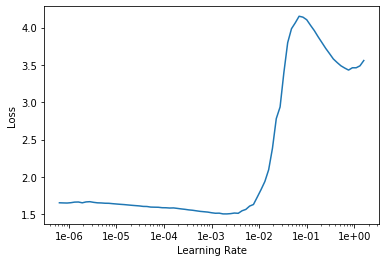

In [212]:
learn.recorder.plot()

In [222]:
lr=1e-4
learn.fit_one_cycle(4, slice(lr/10, lr))

epoch,train_loss,valid_loss,time
0,1.653666,1.502828,00:08
1,1.546066,1.327390,00:07
2,1.473359,1.318814,00:07
3,1.413517,1.304678,00:07


In [214]:
learn.unfreeze()

In [215]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


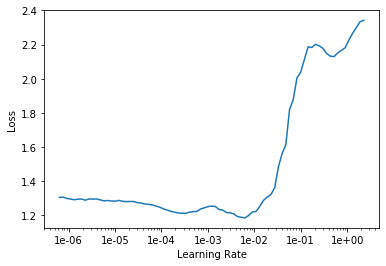

In [216]:
learn.recorder.plot()

In [223]:
lr=1e-4
learn.fit_one_cycle(8, slice(lr/10, lr))

epoch,train_loss,valid_loss,time
0,1.299623,1.300660,00:07
1,1.259554,1.243023,00:07
2,1.234340,1.171744,00:07
3,1.205267,1.131191,00:08
4,1.177660,1.100156,00:08
5,1.140453,1.081105,00:07
6,1.121175,1.075754,00:07
7,1.104918,1.072687,00:07


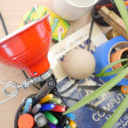

In [229]:
learn.data.train_ds[0][0]

In [230]:
x, y = learn.data.one_batch()

In [233]:
learn.model(x.to('cuda')

SyntaxError: unexpected EOF while parsing (<ipython-input-233-8bcf59f9f0e1>, line 1)

In [239]:
learn.data

AttributeError: 'Tensor' object has no attribute 'apply_tfms'

In [237]:
img,target = next(iter(data.valid_dl))
# with torch.no_grad():
#     output = learn.model(img)

AttributeError: Caught AttributeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/fastai/data_block.py", line 651, in __getitem__
    x = x.apply_tfms(self.tfms, **self.tfmargs)
AttributeError: 'Tensor' object has no attribute 'apply_tfms'


In [236]:
target

NameError: name 'target' is not defined

In [186]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [187]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 64]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
______________________________________________________________________
MaxPool2d            [64, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [64, 32, 32]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 32, 32]         128        True      
______________________________________________________________________
ReLU                 [64, 32, 32]         0          False     
___________________________________________________

In [188]:
learn.loss_func

MyLoss()

- Hmmmm, ok...

In [194]:
x,y =learn.data.one_batch()

In [195]:
x.shape

torch.Size([64, 3, 128, 128])

In [196]:
len(y)

2

In [197]:
y[0].shape, y[1].shape

(torch.Size([64, 1, 4]), torch.Size([64, 1]))

In [199]:
yhat=learn.model(x.to('cuda'))

In [202]:
yhat.unsqueeze_(1).shape

torch.Size([64, 1, 4])

- Hmmmm - how to handle this...Definitley good fastai practice!
- What's the fastai way to handle this - I guess either take it out of the data loader or modify the loss function?
- I feel like not having it in the dataloader is probalby the way to go?
- Hey it would also be interesting to **use the same exact network I used in classification**, so it would be like pretrained on classification.